In [2]:
#import os
#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#
from sklearn.model_selection import train_test_split
# Поиск по сетке оптимальных гиперпараметров модели обучения,
# с применением алгоритма кросс-валидации
from sklearn.model_selection import GridSearchCV
# Модель Gradient Boosting (для задач классификаии)
from sklearn.ensemble import GradientBoostingClassifier
# Метрика (оценка) для задач классификации: accuracy, precision и recall
from sklearn.metrics import accuracy_score #, precision_score, recall_score
# Матрица ошибок классификации и метод для вычисления ошибок 1-го и 2-го рода
from sklearn.metrics import confusion_matrix, classification_report
# Инструменты для визуализации матрицы ошибок
from sklearn.metrics import ConfusionMatrixDisplay

%matplotlib inline
#sep = os.sep

In [8]:
# Анализ оттока клиентов - Часть 3 - Градиентный бустинг и поиск по сетке

In [4]:
# Загрузить данные в DataFrame из csv-файла
df = pd.read_csv('Telco-Customer-Churn.csv')
df.sample(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
2712,0244-LGNFY,Female,0,Yes,Yes,72,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,Two year,No,Bank transfer (automatic),92.65,6733.00,No
6090,7711-GQBZC,Female,0,Yes,Yes,71,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic),24.70,1810.55,No


In [5]:
# Признаки - Features
X = df.drop('Churn', axis='columns')
# Целевая переменная
y = df['Churn']

In [6]:
# Удалить из признаков колонку 'customerID'
X = X.drop('customerID', axis='columns')

In [7]:
# Получить только текстовые колонки из DataFrame'a
myObjectDf = X.select_dtypes(include='object')
#print(myObjectDf); print()

# Получить все колонки исключая текстовые из DataFrame'a
myNumericDf = X.select_dtypes(exclude='object')
#print(myNumericDf); print()

# Создать из категориальных переменных Dummy переменные (one hot encoding)
myDummiesDf = pd.get_dummies(myObjectDf, drop_first=True)

for col in myDummiesDf.columns:
    tmp = myDummiesDf[col].apply(int)
    myDummiesDf[col] = tmp

X = pd.concat([myNumericDf, myDummiesDf], axis='columns')

In [49]:
# Разбить набор данных на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=101)

In [50]:
# Создать объект модели обучения
gradBoostModel = GradientBoostingClassifier()

# Значения гиперпараметров модели обучения, которые будут проверяться как оптимальные
paramsGrid = {
    # Количество деревьев решений
    'n_estimators': [20, 50, 100],
    # Коэффициент обучения
    'learning_rate': [0.05, 0.1, 0.2],
    # Глубина деревьев решений
    'max_depth': [3, 4, 5]
}

# Поиск по сетке
gridSearchCV = GridSearchCV(
    # Модель, которую нужно обучить
    estimator=gradBoostModel,
    # Списки значений гиперпараметров, из которых нужно найти оптимальные
    param_grid=paramsGrid,
    # На сколько частей разбить тренировочные данные
    # для алгоритма кросс-валидации
    cv=5,
    # Чем больше значение, тем больше выводить информации на экран
    verbose=1
)

# Найти оптимальную комбинацию гиперпараметров (с помощью метода кросс-валидации)
# и вернуть на выходе обученную модель
gridSearchCV.fit(X_train, y_train)

# Какая комбинация гиперпараметров лучшая
bestParams = gridSearchCV.best_params_
bestParams

Fitting 5 folds for each of 27 candidates, totalling 135 fits


{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

In [51]:
# Вычислить вероятности целевых переменных, на основе обученной модели
yPredictProbability = gridSearchCV.predict_proba(X_test)
#yPredictProbability

In [52]:
print(y_test.iloc[0], yPredictProbability[0])
print(y_test.iloc[1], yPredictProbability[1])

Yes [0.57991653 0.42008347]
No [0.98388404 0.01611596]


In [53]:
# Вычислить целевые переменные, на основе обученной модели
yPredict = gridSearchCV.predict(X_test)
#yPredict

In [54]:
# Оценки (метрики)

In [55]:
# Accuracy - Процент правильных ответов
accuracy = accuracy_score(y_test, yPredict)
print(f'Accuracy: {accuracy:0.3f}', end='\n\n')

Accuracy: 0.797



In [56]:
# Матрица с метриками (по отдельным классам): Precision, Recall и F1-score
# F1-score - Гармоническое среднее между Precision и Recall
# support - Количество значений отдельных классов, в тестовом наборе данных
# macro avg - Обычное среднее
# weighted avg - Взвешенное среднее, с учетом количества значений отдельных классов
classificationReport = classification_report(y_test, yPredict)
print(classificationReport)

              precision    recall  f1-score   support

          No       0.84      0.90      0.87      1033
         Yes       0.65      0.51      0.57       374

    accuracy                           0.80      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.79      0.80      0.79      1407



In [57]:
# Вычислить матрицу ошибок
# По главной диагонали: правильные ответы.
# По второй диагонали: ошибки
# confusionMatrix[0][1]: Модель выдала True, там где на самом деле было Fale
# confusionMatrix[1][0]: Модель выдала False, там где на самом деле было True
confusionMatrix = confusion_matrix(y_test, yPredict)
confusionMatrix

array([[930, 103],
       [182, 192]], dtype=int64)

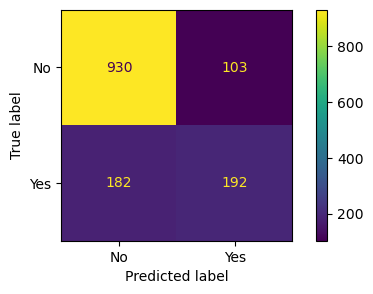

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 3), dpi=100)
# Визуализация матрицы ошибок (на графике)
ConfusionMatrixDisplay.from_estimator(
    # обученная модель
    estimator=gridSearchCV,
    # тестовый набор данных
    X=X_test,
    y=y_test,
    # связать график с Matplotlib
    ax=axes
);

In [59]:
# Доступ к обученной модели
gridSearchCV.best_estimator_

GradientBoostingClassifier(max_depth=5)

In [61]:
# Важность признаков для обученной модели
featureImportances = gridSearchCV.best_estimator_.feature_importances_
featuresDF = pd.DataFrame(data=featureImportances, index=X.columns, columns=['importance'])
# Оставить только признаки, важность которых > 0.005
importanceFeatures = featuresDF[featuresDF['importance'] > 0.005]
importanceFeatures = importanceFeatures.sort_values(by='importance')
#importanceFeatures

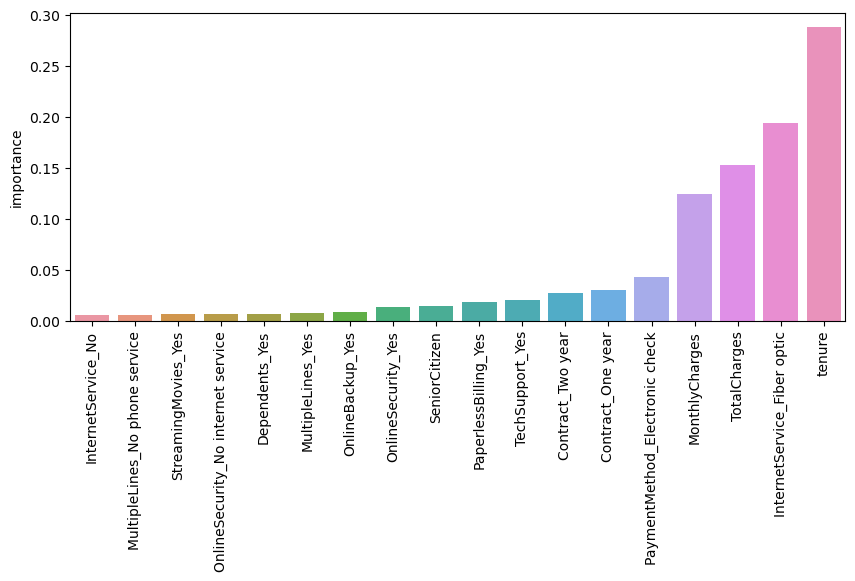

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 4), dpi=100)
# Строим график:
sns.barplot(data=importanceFeatures, x=importanceFeatures.index, y='importance')
plt.xticks(rotation=90);

In [ ]:
# Извините, можно шаг с XGBoost, CatBoost, LightGBM пропустить!
# Весь код останется точно таким же. Изменятся только метрики качества.

# И да, я понимаю, что главная задача здесь - распознать клиентов, которые могут уйти в отток.
# Метрика recall для такой задачи, мягко говоря, неудовлетворительная.
# Но для учебных целей может будет простительно